### Lunar Lander bot training

In [73]:
!pip install -r requirements.txt

In [74]:
!pip install "gymnasium[box2d]"

In [75]:
import time

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn as sns

In [76]:
np.random.seed(2137) 

In [77]:
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5)
env.reset()
env.render()

#### Discretize observation space

In [78]:
NUM_BINS = 8

def discretize_observation_space(env, num_bins):
    observation_space = env.observation_space
    bins = [
        np.linspace(observation_space.low[i], observation_space.high[i], num_bins + 1)[1:-1]
        for i in range(observation_space.shape[0])
    ]
    return bins

# Function to convert continuous state to discrete state
def get_discrete_state(state, bins):
    return tuple(np.digitize(state[i], bins[i]) for i in range(len(bins)))

bins = discretize_observation_space(env, NUM_BINS)
state = env.reset()[0]  # Reset the environment and get the initial state
discrete_state = get_discrete_state(state, bins)
print("Discrete State:", discrete_state)

Discrete State: (4, 6, 4, 4, 3, 3, 0, 0)


### Training

In [79]:
#Setting the hyperparameters

max_epsilon = 1
min_epsilon = 0.01
decay = 0.01

train_episodes = 20000
test_episodes = 100          
max_steps = 100

In [80]:
# Modify the QLearner class to work with discrete states

class QLearner:
    def __init__(self, bins, n_actions):
        self.bins = bins  # Discretization bins
        self.n_actions = n_actions
        self.Q = np.zeros([np.prod([len(b) + 1 for b in bins]), n_actions])  # Q-table
        self.alpha = 0.8  # Learning rate
        self.discount_factor = 0.7  # Discount factor
        self.epsilon = 1  # Exploration rate

    def get_state_index(self, state):
        """Convert a discrete state tuple to a single index for the Q-table."""
        indices = [np.digitize(state[i], self.bins[i]) for i in range(len(self.bins))]
        return np.ravel_multi_index(indices, [len(b) + 1 for b in self.bins])

    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy."""
        state_index = self.get_state_index(state)
        if random.uniform(0, 1) > self.epsilon:
            return np.argmax(self.Q[state_index, :])  # Exploit
        else:
            return random.randint(0, self.n_actions - 1)  # Explore

    def update_Q(self, state, new_state, action, reward):
        """Update the Q-table using the Bellman equation."""
        state_index = self.get_state_index(state)
        new_state_index = self.get_state_index(new_state)
        self.Q[state_index, action] += self.alpha * (
            reward + self.discount_factor * np.max(self.Q[new_state_index, :]) - self.Q[state_index, action]
        )

# Initialize the QLearner with discretized observation space
bins = discretize_observation_space(env, NUM_BINS)
agent = QLearner(bins, env.action_space.n)

# Example usage
state = env.reset()[0]
discrete_state = get_discrete_state(state, bins)

# Choose an action
action = agent.choose_action(discrete_state)

# Take a step in the environment
new_state, reward, done, _, _ = env.step(action)
discrete_new_state = get_discrete_state(new_state, bins)

# Update the Q-table
agent.update_Q(discrete_state, discrete_new_state, action, reward)

In [81]:
#Training the agent

#Creating lists to keep track of reward and epsilon values
training_rewards = []  
epsilons = []

def train_agent():
    for episode in range(train_episodes):
        # Reseting the environment each time as per requirement
        state, info = env.reset()
        # Starting the tracker for the rewards
        total_training_rewards = 0

        for step in range(100):
            action = agent.choose_action(state)
            ### STEPs 3 & 4: performing the action and getting the reward
            # Taking the action and getting the reward and outcome state
            new_state, reward, terminated, truncated, info = env.step(action)

            agent.update_Q(state, new_state, action, reward)
            total_training_rewards += reward
            state = new_state

            # Ending the episode
            if terminated or truncated:
                # print ("Total reward for episode {}: {}".format(episode, total_training_rewards))
                break

        # Cutting down on exploration by reducing the epsilon
        agent.epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay*episode)

        # Adding the total reward and reduced epsilon values
        training_rewards.append(total_training_rewards)
        epsilons.append(agent.epsilon)


train_agent()

print("Training score over time: " + str(sum(training_rewards)/train_episodes))

Training score over time: -8.730351288194267


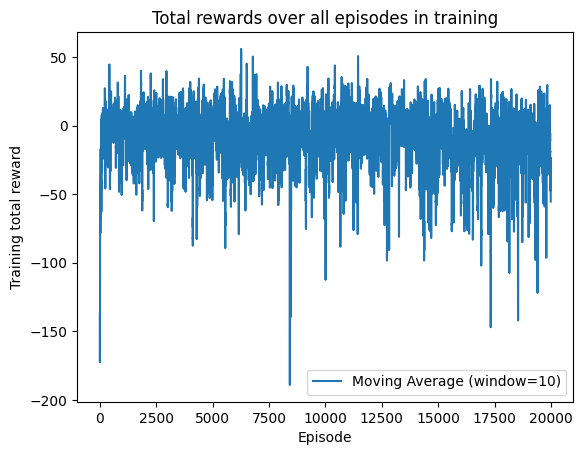

In [82]:
# Modify the reward visualization cell to include a moving average

#Visualizing results and total reward over all episodes
window_size = 10
moving_avg = np.convolve(training_rewards, np.ones(window_size)/window_size, mode='valid')

x = range(len(moving_avg))
plt.plot(x, moving_avg, label='Moving Average (window=10)')
# plt.plot(range(len(training_rewards)), training_rewards, alpha=0.3, label='Original Rewards')
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training')
plt.legend()
plt.show()

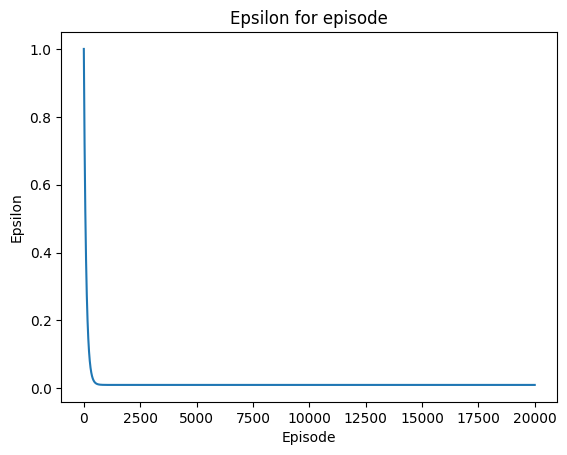

In [83]:
#Visualizing the epsilons over all episodes
plt.plot(epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon for episode")
plt.show()

### Learner with decreases alpha

In [84]:
class QLearner_v2:
    def __init__(self, bins, n_actions):
        self.bins = bins  # Discretization bins
        self.n_actions = n_actions
        self.Q = np.zeros([np.prod([len(b) + 1 for b in bins]), n_actions])  # Q-table
        self.state_visits = np.zeros(np.prod([len(b) + 1 for b in bins]))  # Track state visit counts
        self.discount_factor = 0.7  # Discount factor
        self.epsilon = 1  # Exploration rate

    def get_state_index(self, state):
        """Convert a discrete state tuple to a single index for the Q-table."""
        indices = [np.digitize(state[i], self.bins[i]) for i in range(len(self.bins))]
        return np.ravel_multi_index(indices, [len(b) + 1 for b in self.bins])

    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy."""
        state_index = self.get_state_index(state)
        if random.uniform(0, 1) > self.epsilon:
            return np.argmax(self.Q[state_index, :])  # Exploit
        else:
            return random.randint(0, self.n_actions - 1)  # Explore

    def update_Q(self, state, new_state, action, reward):
        """Update the Q-table using the Bellman equation with dynamic learning rate."""
        state_index = self.get_state_index(state)
        new_state_index = self.get_state_index(new_state)

        # Increment visit count for the current state
        self.state_visits[state_index] += 1

        # Calculate dynamic learning rate
        alpha = 60 / (59 + self.state_visits[state_index])

        # Update Q-value using the Bellman equation
        self.Q[state_index, action] += alpha * (
            reward + self.discount_factor * np.max(self.Q[new_state_index, :]) - self.Q[state_index, action]
        )

# Initialize the QLearner with discretized observation space
bins = discretize_observation_space(env, NUM_BINS)
agent_2 = QLearner_v2(bins, env.action_space.n)

In [85]:
#Training the agent_2

#Creating lists to keep track of reward and epsilon values
training_rewards_2 = []  
epsilons_2 = []

def train_agent_2():
    for episode in range(train_episodes):
        # Reseting the environment each time as per requirement
        state, info = env.reset()
        # Starting the tracker for the rewards
        total_training_rewards_2 = 0

        for step in range(100):
            action = agent_2.choose_action(state)
            ### STEPs 3 & 4: performing the action and getting the reward
            # Taking the action and getting the reward and outcome state
            new_state, reward, terminated, truncated, info = env.step(action)

            agent_2.update_Q(state, new_state, action, reward)
            total_training_rewards_2 += reward
            state = new_state

            # Ending the episode
            if terminated or truncated:
                # print ("Total reward for episode {}: {}".format(episode, total_training_rewards_2))
                break

        # Cutting down on exploration by reducing the epsilon
        agent_2.epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay*episode)

        # Adding the total reward and reduced epsilon values
        training_rewards_2.append(total_training_rewards_2)
        epsilons_2.append(agent_2.epsilon)


train_agent_2()

print("Training score over time: " + str(sum(training_rewards_2)/train_episodes))

Training score over time: -6.615373915410124


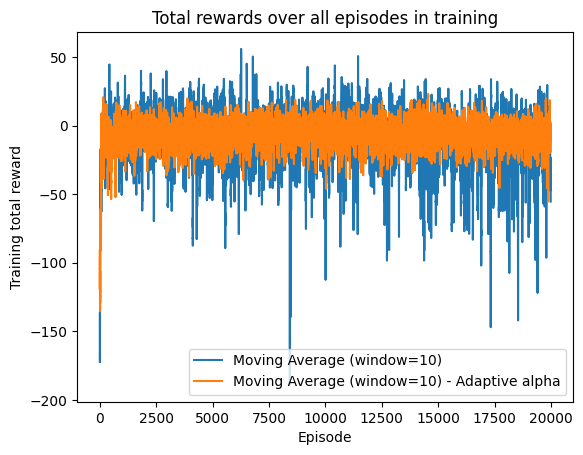

In [86]:
#Visualizing results and total reward over all episodes
window_size = 10
moving_avg_2 = np.convolve(training_rewards_2, np.ones(window_size)/window_size, mode='valid')

x = range(len(moving_avg))
plt.plot(x, moving_avg, label='Moving Average (window=10)')
plt.plot(x, moving_avg_2, label='Moving Average (window=10) - Adaptive alpha')
# plt.plot(range(len(training_rewards)), training_rewards, alpha=0.3, label='Original Rewards')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training')
plt.legend()
plt.show()

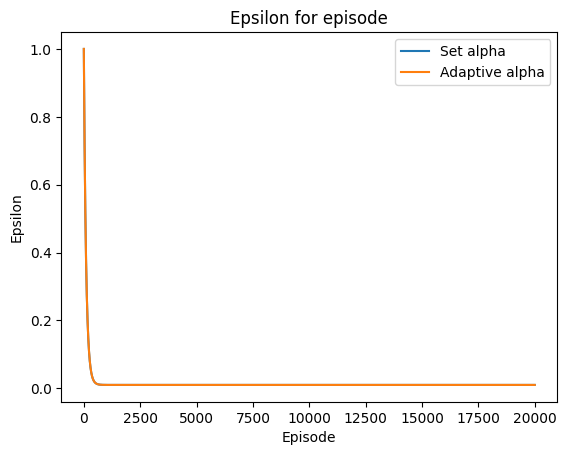

In [87]:
#Visualizing the epsilons over all episodes
plt.plot(epsilons)
plt.plot(epsilons_2)
plt.legend(['Set alpha', 'Adaptive alpha'])
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon for episode")
plt.show()